In [32]:
# установка необх.библиотек
# import sys
!pip3 install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

!pip3 install pandas
!pip3 install xlrd
!pip3 install scipy
!pip3 install statsmodels
!pip3 install matplotlib
!pip3 install seaborn

Requirement already up-to-date: google-api-python-client in /Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages (1.12.3)
Requirement already up-to-date: google-auth-httplib2 in /Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages (0.0.4)
Requirement already up-to-date: google-auth-oauthlib in /Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages (0.4.1)
     |████████████████████████████████| 103 kB 581 kB/s eta 0:00:01


In [8]:
# импорты 
import io
from googleapiclient.http import MediaIoBaseDownload
import googleapiclient.discovery
from apiclient import discovery
from httplib2 import Http
import oauth2client
from oauth2client import file, client, tools

import pandas as pd
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [13]:
# немного настроек для графиков
%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                 

In [3]:
# проводим аутентификацию через гугловую апишку

obj = lambda: None
lmao = {"auth_host_name":'localhost', 'noauth_local_webserver':'store_true', 'auth_host_port':[8080, 8090], 'logging_level':'ERROR'}
for k, v in lmao.items():
    setattr(obj, k, v)
    
# authorization boilerplate code
SCOPES = 'https://www.googleapis.com/auth/drive.readonly'
store = file.Storage('token.json')
creds = store.get()
# The following will give you a link if token.json does not exist, the link allows the user to give this app permission
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('credential/credentials.json', SCOPES)
    creds = tools.run_flow(flow, store, obj)

/Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages/oauth2client/_helpers.py:255: UserWarning: Cannot access token.json: No such file or directory
  warnings.warn(_MISSING_FILE_MESSAGE.format(filename))



Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=783548059285-jduaap6ga9va97jpeit08lfaohlq1bvv.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.readonly&access_type=offline&response_type=code

Enter verification code: 4/1AfDhmrimGjVvJ8VDSny1Fyb5Jj2r-iHyT588-DlTIU43YtXEn4Sf7soXwQs
Authentication successful.


In [4]:
# путь к исходному файлу с результатами теста
path_to_file = './data/split_form.xlsx'

In [5]:
# считываем необходимый файл. Удобно забирать прямо с диска - все изменения на диске тянем сразу 
#  (перезаписываем файл на локальной машине)

DRIVE = googleapiclient.discovery.build(serviceName='drive'
                                        , version='v3'
                                        , http=creds.authorize(Http()))
# if you get the shareable link, the link contains this id, replace the file_id below

file_id = '16-kZKQIdjeKErkEyPilollVPCj2CHzy1'
request = DRIVE.files().get_media(fileId=file_id)
# replace the filename and extension in the first field below
fh = io.FileIO(path_to_file, mode='w')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100)) 

Download 100%.


# Формулировка гипотезы

**Если убрать поле для ввода Name on card, то вырастет конверсия в нажатие кнопки Pay, т.к. пользователям придётся вводит меньше данных.
P.S. Хорошо бы чертить "линию на песке" - ожидаемый % роста конверсии.

# Choosing a sample size

First things first, we want to make sure we formulate a hypothesis at the start of our project. This will make sure our interpretation of the results is correct as well as rigorous.
Given we don’t know if the new design will perform better or worse (or the same?) as our current design, we’ll choose a two-tailed test:
Hₒ: p = pₒ
Hₐ: p ≠ pₒ
where p and pₒ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 95%:
α = 0.05
The α value is a threshold we set, by which we say “if the probability of observing a result as extreme or more (p-value) is lower than α, then we reject the Null hypothesis”. Since our α=0.05 (indicating 5% probability), our confidence (1 — α) is 95%.

how many people should we have in each group?

The sample size we need is estimated through something called Power analysis, and it depends on a few factors:
    # Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)
    # Alpha value (α) — The critical value we set earlier to 0.05
    # Effect size — How big of a difference we expect there to be between the conversion rates

In [105]:

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(f'We’d need at least {required_n} observations for each group')

We’d need at least 4720 observations for each group


Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

In [6]:
# чтение файла в датафрейм
split = pd.read_excel(path_to_file)

split.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
7617,SAMSUNG,CHROME MOBILE,SMARTPHONE,0,new,AND,7,360x640,5127365,MOB
9061,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,7,360x720,4391393,MOB
23515,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,4.4,360x640,6022098,MOB


In [10]:
# No action required: Leave the original dataframe untouched and sort the new dataframe
split2 = split.copy()

In [285]:
split2.sample(6)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
186,Other,FIREFOX,DESKTOP,1,old,WIN,7,1366x768,3903731,WEB
12185,HUAWEI,CHROME MOBILE,SMARTPHONE,0,new,AND,5.1,360x640,5025236,MOB
18289,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,7,360x640,4982749,MOB
22189,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,5.1,360x640,3863865,MOB
9493,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,5.1,360x640,4694762,MOB
6415,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,5.1,320x570,4264237,MOB


In [17]:
# из-за отсутствия id_user сделаю проверку по идентификатору визита
session_counts = split2['idvisit'].value_counts(ascending=False)
multi_visit = session_counts[session_counts > 1].count()

print(f'There are {multi_visit} users that appear multiple times in the dataset')

# окей с отсутствием дублей

There are 0 users that appear multiple times in the dataset


In [18]:
# список измерений для группировки и вычислений
diminsion_col = ['DEVICES_BRANDS', 'BROWSERS', 'DEVICE_TYPE', 'Conversion'
                 , 'A/B', 'config_os', 'config_os_version', 'config_resolution', 'platform_v4']

In [19]:
# считаем кол-во визитов в разрезе необходимых измерений
split2['visit_cnt'] = split2.groupby(diminsion_col)['idvisit'].transform('count')


split2 = split2.astype({"visit_cnt": int}, errors='ignore')

split2 = split2.filter(['DEVICES_BRANDS', 'BROWSERS', 'DEVICE_TYPE', 'Conversion'
                 , 'A/B', 'config_os', 'config_resolution', 'config_os_version', 'platform_v4', 'visit_cnt'])

split2.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_resolution,config_os_version,platform_v4,visit_cnt
6373,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,320x534,5.1,MOB,24.0
20919,APPLE,MOBILE SAFARI,SMARTPHONE,0,old,IOS,375x667,10.2,MOB,4.0
1725,Other,CHROME,DESKTOP,1,new,WIN,1366x768,7,WEB,39.0


In [20]:
# что там по конверсии в разных группах?
pd.crosstab(split2['A/B'], split2['Conversion']
            , margins=True, margins_name="Total")

Conversion,0,1,Total
A/B,,,
new,13564,1865,15429
old,9806,1350,11156
Total,23370,3215,26585


Присущий неравномерно распределенный трафик в тестовой и контрольной группе. Почему 

## Sampling

In [131]:
# random_state=22 для воспроизводимости результатов
control_sample = split2[split2['A/B'] == 'old'].sample(n=required_n, random_state=22)
test_sample = split2[split2['A/B'] == 'new'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, test_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
826,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,7,360x640,3948689,MOB
4675,Other,CHROME,DESKTOP,0,old,WIN,8.1,1366x768,3886627,WEB
8054,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,6,360x640,6097537,MOB


In [132]:
# List of names of unique names of the segments
brows_list = list(split2['BROWSERS'].unique())
dev_br_list = list(split2['DEVICES_BRANDS'].unique())
dev_type_list = list(split2['DEVICE_TYPE'].unique())
platf_list = list(split2['platform_v4'].unique())

In [133]:
# Count of the number of segments (or total test variations)
variations_brows = len(brows_list)
variations_dev_brand = len(dev_br_list)
variations_dev_type = len(dev_type_list)
variations_platf = len(platf_list)

# Verify that the segments/categories are correct 
print('Different brow: ',brows_list, 'Number of segments: ', variations_brows)
print('Different dev brand: ',dev_br_list, 'Number of segments: ', variations_dev_brand)
print('Different device type: ',dev_type_list, 'Number of segments: ', variations_dev_type)
print('Different version platform: ',platf_list, 'Number of segments: ', variations_platf)

Different brow:  ['CHROME MOBILE', 'Other', 'MOBILE SAFARI', 'CHROME', 'FIREFOX'] Number of segments:  5
Different dev brand:  ['Other', 'SAMSUNG', 'APPLE', 'HUAWEI'] Number of segments:  4
Different device type:  ['SMARTPHONE', '-99', 'PHABLET', 'DESKTOP', 'TABLET', 'PORTABLE_MEDIA_PAYER'] Number of segments:  6
Different version platform:  ['MOB', 'WEB'] Number of segments:  2


## Visualising the results

In [291]:
conversion_rates = ab_test.groupby(['A/B'])['Conversion']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
A/B,,,
new,0.125,0.331,0.005
old,0.126,0.331,0.005


Text(0, 0.5, 'Converted (proportion)')

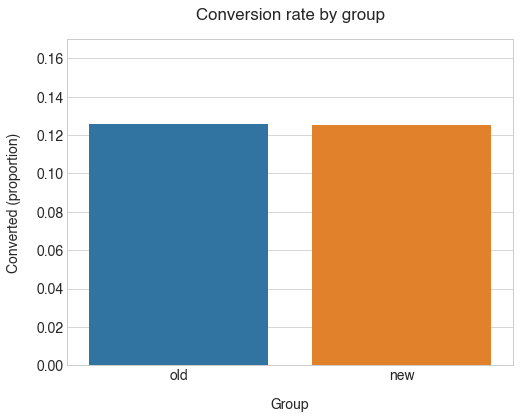

In [292]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['A/B'], y=ab_test['Conversion'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

# Конверсия по типу платформы (Conversions Per Platform)

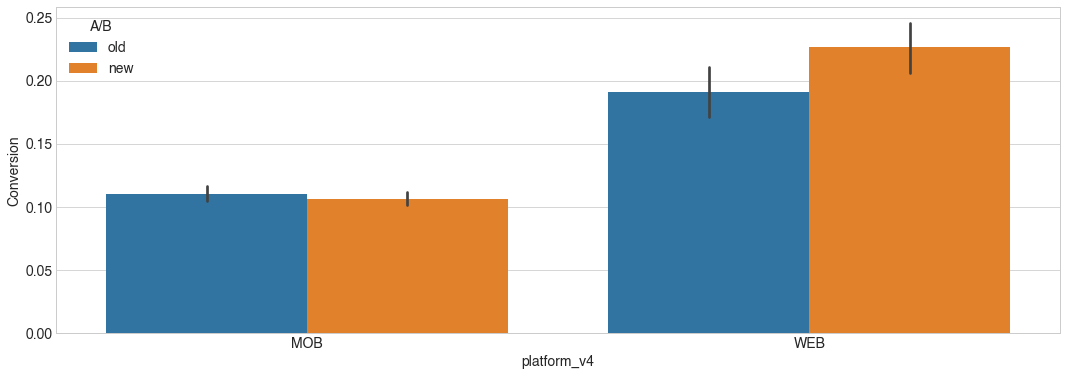

In [14]:
# platform_v4

fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='platform_v4'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

### По новой форме конверсия на WEB (порядка 22% в тестовой группе) показивает рост, в отличии от МОВ. Необходимо рассмотреть более детально срезы по этой платформе.

# **Конверсия по типу девайса (Conversions Per Device)**

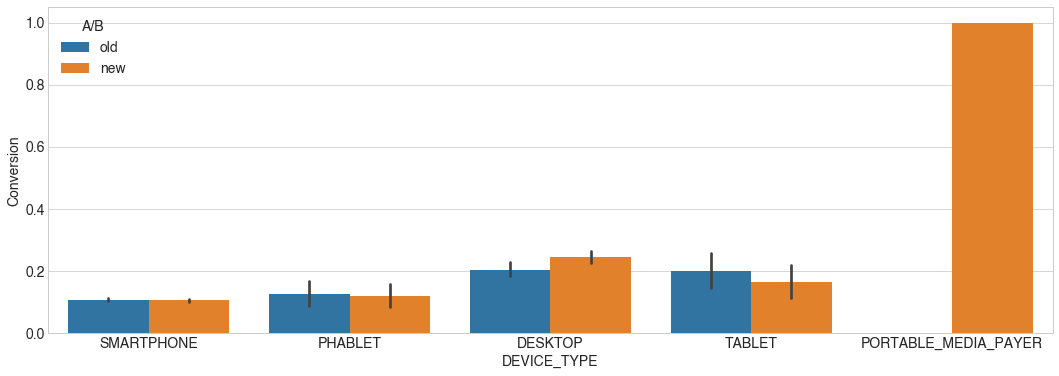

In [15]:
# DEVICE_TYPE в целом
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICE_TYPE'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

## Идет просадка на смартфонах и фаблетах (гибрид телефона+планшета), важно понять какую долю они занимают в структуре трафика? поскольку практически 90% (нижняя визуализация), то необходимо понять, что внутри не так...

<AxesSubplot:ylabel='visit_cnt'>

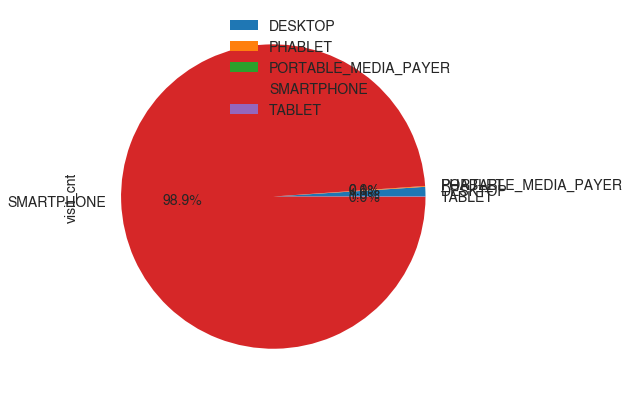

In [29]:
split2.groupby(['DEVICE_TYPE']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(18,7)
                                             , autopct='%1.1f%%')

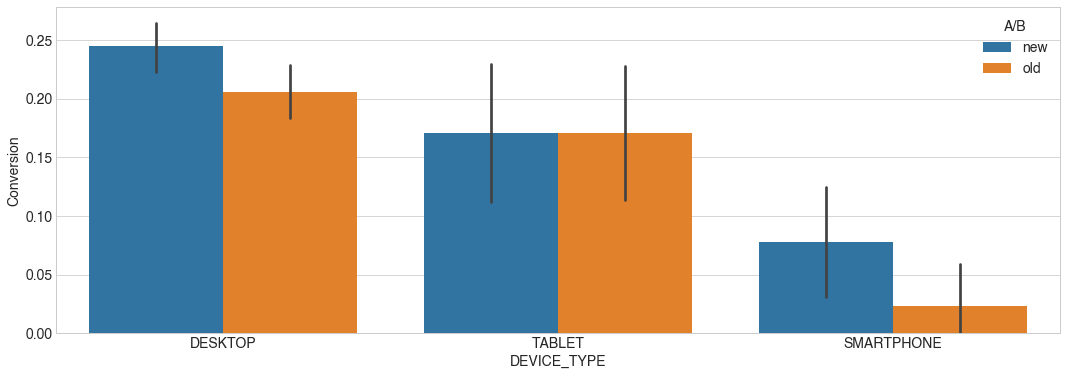

In [30]:
# DEVICE_TYPE на вебе 
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICE_TYPE'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='WEB'], ax=ax)
plt.show()

### такс... ????? что-то тут не согласовуется с верхним по росту на вебе

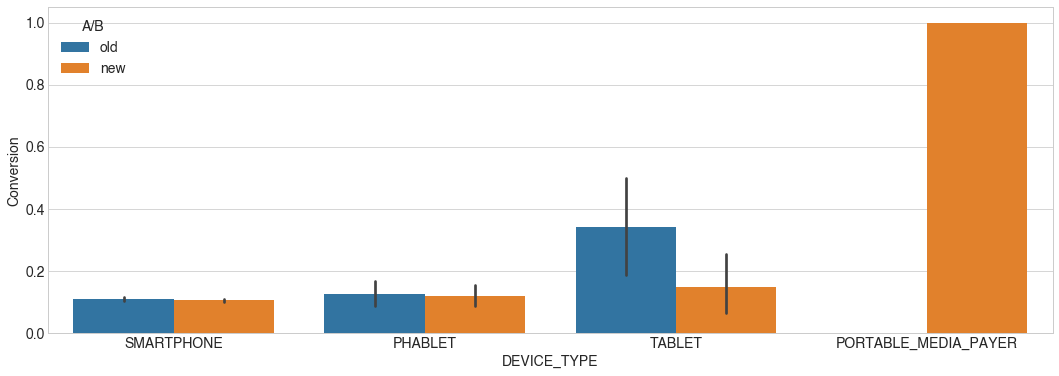

In [31]:
# DEVICE_TYPE на вебе
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICE_TYPE'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='MOB'], ax=ax)
plt.show()

# **Конверсия по типу операционной системы**

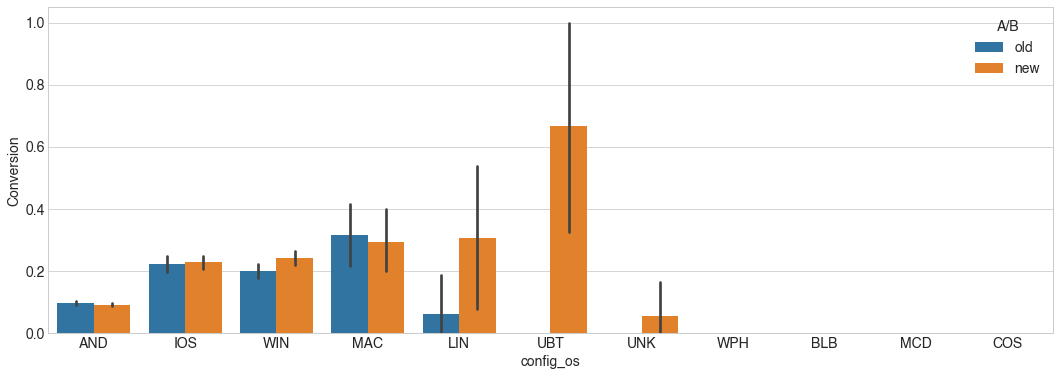

In [32]:
# config_os
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='config_os'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

## Коэффициент конверсии на iOS разнится от коэффициента на Android, в последнего идёт понижение. Возможно, при разработке что-то не учтено. И если брать во внимание трафик (нижний график) с Android, то понижение - плохо, т.к. это практически он занимает всю структуру.

<AxesSubplot:ylabel='visit_cnt'>

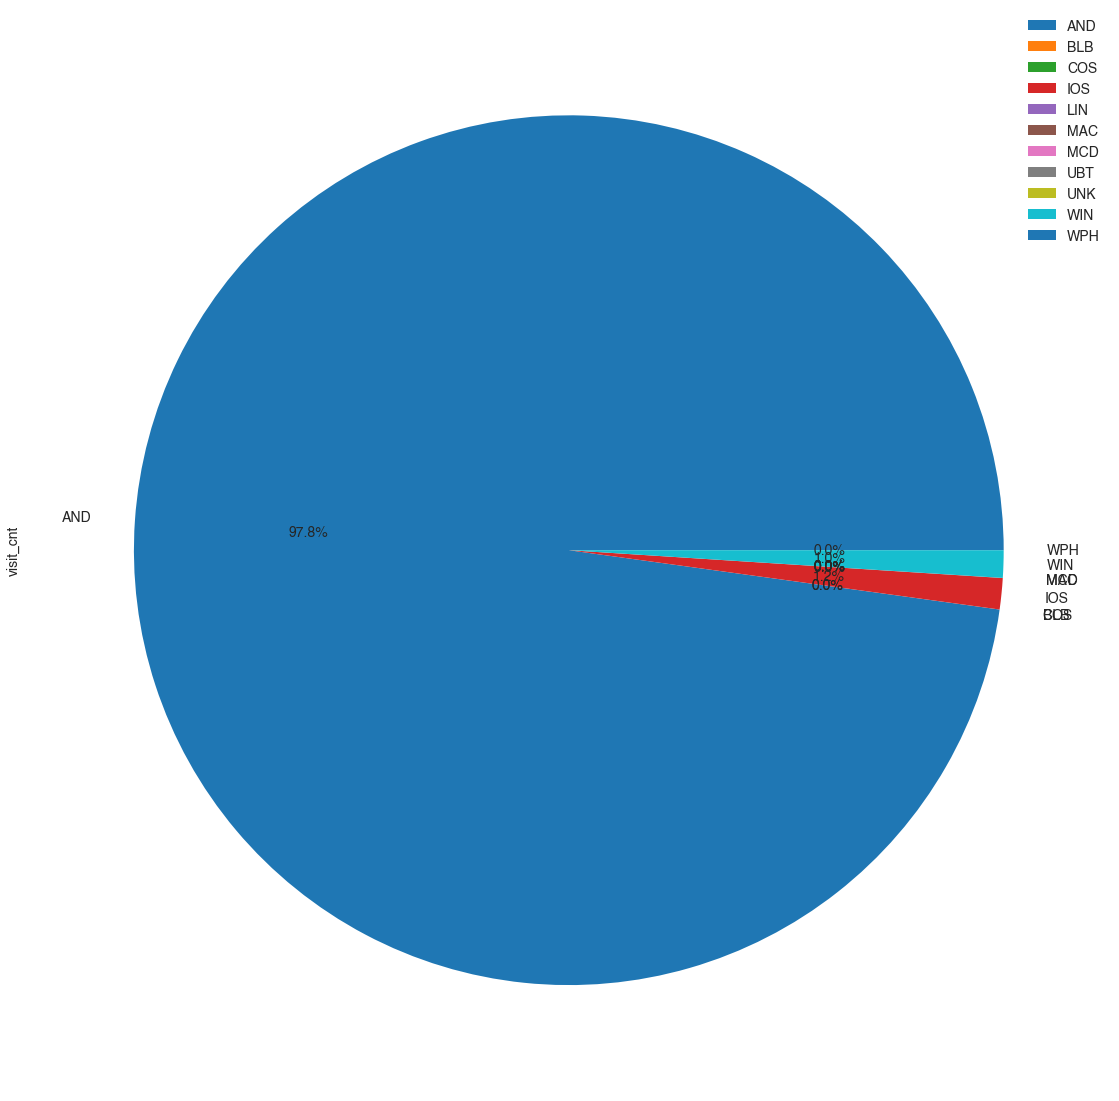

In [33]:
split2.groupby(['config_os']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(20,20)
                                             , autopct='%1.1f%%')

## Пойдем глянем в марку Android-девайсов

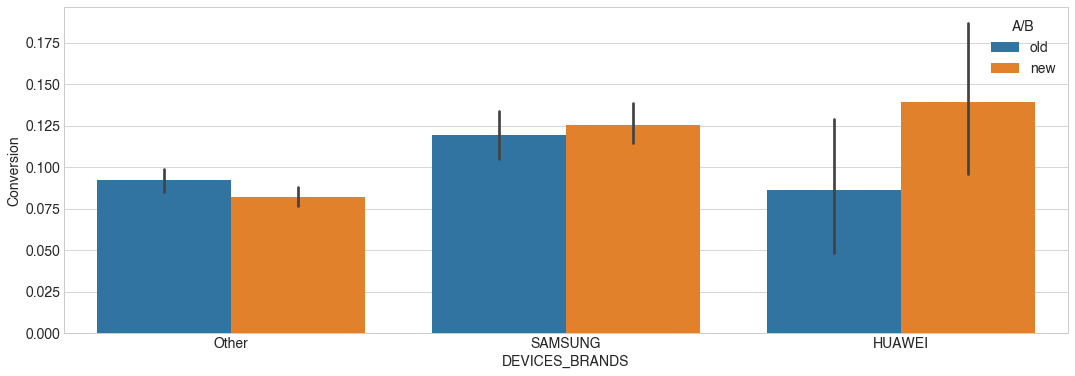

In [34]:
# DEVICES_BRANDS
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICES_BRANDS'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.config_os=='AND'], ax=ax)
plt.show()

<AxesSubplot:ylabel='visit_cnt'>

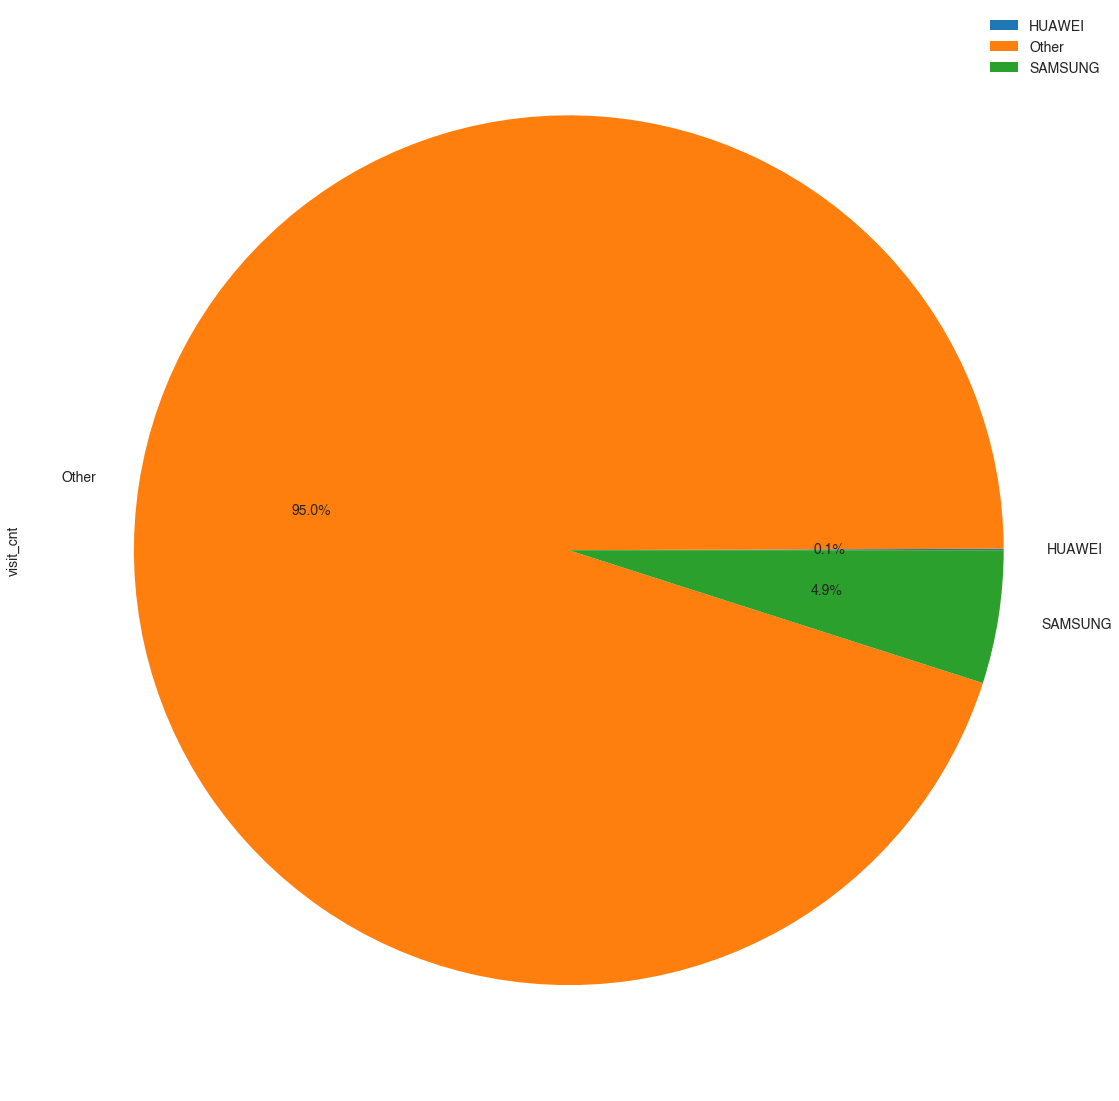

In [35]:
split2[split2.config_os=='AND'].groupby(['DEVICES_BRANDS']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(20,20)
                                             , autopct='%1.1f%%')

## Предполагаю, что нюанс может быть с конфигами

In [57]:
data=split2[(split2.config_os=='AND')
                          &(split2.DEVICES_BRANDS=='Other')]

conversion_rates = data.groupby(['config_resolution', 'A/B'])['Conversion']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean]).sort_values(by=['config_resolution', 'A/B'], ascending=False)


pd.set_option('display.max_rows', conversion_rates.shape[0]+1)
conversion_rates

mean
config_resolution A/B          
976x610           old  0.000000
                  new  0.000000
962x601           new  0.000000
960x600           old  0.000000
800x1280          old  0.157895
                  new  0.176471
800x1232          old  0.000000
                  new  0.000000
768x976           old  0.000000
768x1024          new  0.000000
720x1440          old  0.000000
                  new  1.000000
720x1280          old  0.000000
                  new  0.000000
681x1090          new  0.000000
640x360           old  0.000000
                  new  0.250000
610x976           old  0.000000
                  new  0.200000
601x962           old  0.100000
                  new  0.000000
601x906           new  0.000000
600x976           old  0.000000
                  new  0.100000
600x960           old  0.000000
600x1024          old  0.044118
                  new  0.050633
570x320           new  0.000000
552x1103          new  0.000000
551x1101          new  0.000000
541x962           old  0.000000
                  new  0.000000
540x960           new  0.000000
540x912           old  0.000000
531x943           old  1.000000
517x881           new  0.000000
501x891           old  0.000000
486x971           old  0.000000
                  new  0.000000
486x863           new  0.500000
486x729           new  0.000000
486x1025          new  0.000000
485x861           old  0.166667
                  new  0.000000
480x855           old  0.000000
480x854           old  0.333333
                  new  0.000000
463x925           old  0.000000
463x822           new  0.000000
458x915           new  0.000000
455x960           old  0.333333
455x809           new  0.500000
451x770           old  0.023256
                  new  0.040000
450x900           old  0.000000
                  new  0.000000
444x788           new  0.000000
439x586           new  0.000000
438x854           old  0.000000
432x864           new  0.000000
432x768           old  0.000000
                  new  0.000000
427x760           new  0.000000
424x895           old  0.000000
                  new  0.000000
424x848           old  0.277778
                  new  0.076923
424x753           old  0.094340
                  new  0.034884
421x748           old  0.000000
                  new  0.000000
414x803           new  0.000000
414x736           old  0.000000
412x869           new  0.250000
412x823           old  0.187500
                  new  0.111111
412x732           old  0.121495
                  new  0.115108
412x618           old  0.000000
                  new  0.176471
410x728           new  0.000000
408x725           new  0.000000
400x800           new  0.000000
400x712           old  0.000000
                  new  0.000000
400x584           old  0.000000
396x664           old  0.000000
                  new  0.500000
393x830           new  0.000000
393x786           old  0.166667
                  new  0.000000
393x699           old  0.105263
                  new  0.043956
384x512           old  0.000000
                  new  0.500000
381x677           new  0.000000
381x676           new  0.333333
377x753           old  0.000000
                  new  0.142857
377x670           old  0.090909
                  new  0.000000
377x628           old  0.000000
                  new  0.250000
376x752           old  0.000000
                  new  0.000000
376x668           new  0.000000
376x564           new  0.000000
372x661           new  0.000000
361x642           old  0.000000
                  new  0.000000
360x780           new  1.000000
360x760           old  0.000000
                  new  0.222222
360x750           old  0.142857
                  new  0.135135
360x720           old  0.098952
                  new  0.084894
360x678           old  0.000000
360x672           old  0.785714
                  new  0.437500
360x668           old  1.000000
                  new  0.285714
360x640           old  0.096845
                  new  0.08

In [58]:
conversion_rates = data.groupby(['config_os_version', 'A/B'])['Conversion']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean]).sort_values(by=['config_os_version', 'A/B'], ascending=False)


pd.set_option('display.max_rows', conversion_rates.shape[0]+1)
conversion_rates

mean
config_os_version A/B          
8.1               old  0.081716
                  new  0.086130
8.0               old  0.152778
                  new  0.101648
7.1               old  0.118919
                  new  0.082645
7.0               old  0.099025
                  new  0.088999
6.1               old  0.153846
                  new  0.071429
6.0               old  0.087973
                  new  0.068409
5.1               old  0.071233
                  new  0.071775
5.0               old  0.102273
                  new  0.088889
4.4               old  0.056250
                  new  0.068120
4.3               old  0.250000
                  new  0.500000
4.2               old  0.333333
                  new  0.000000
4.1               new  0.250000
4.0               old  0.000000
                  new  0.500000

# Конверсия по браузерам (Conversions Per Browser)

<AxesSubplot:ylabel='visit_cnt'>

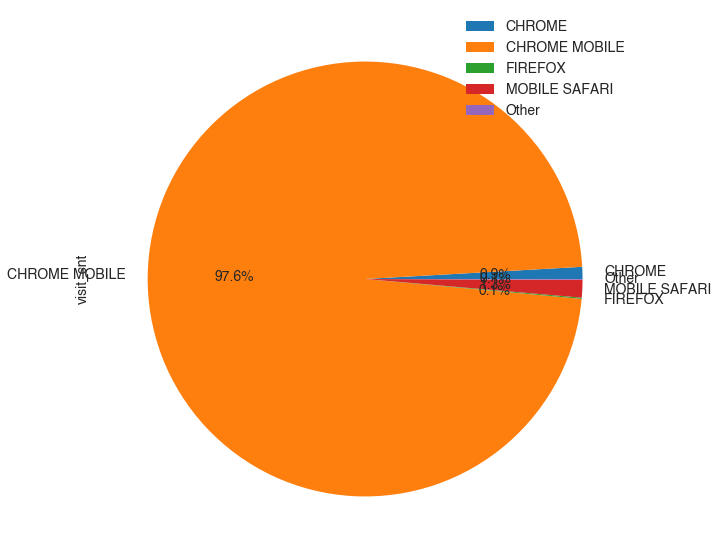

In [270]:
split2.groupby(['BROWSERS']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(20,10)
                                             , autopct='%1.1f%%')

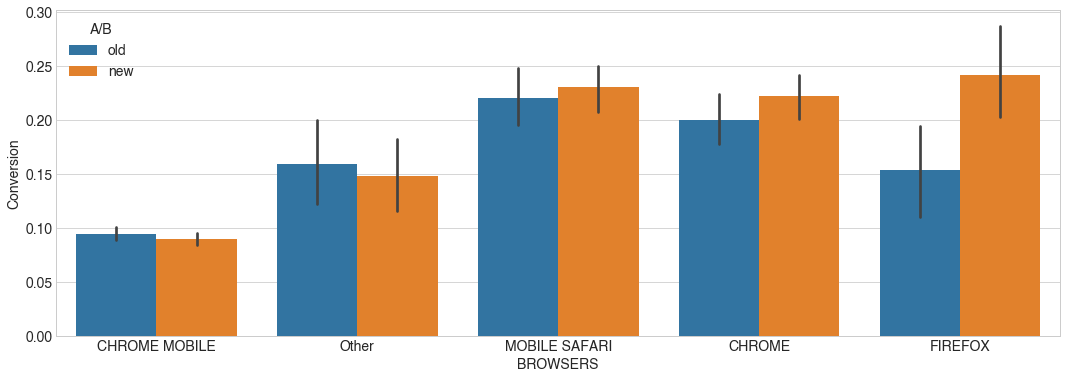

In [259]:
# BROWSERS
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='BROWSERS'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

Потестить, что не так с Chrome mobile и Другие в тестовой группе. Возможно что-то с отобрабражением формы. Т.к. на других - ок.

!!! взять разрешение экрана..

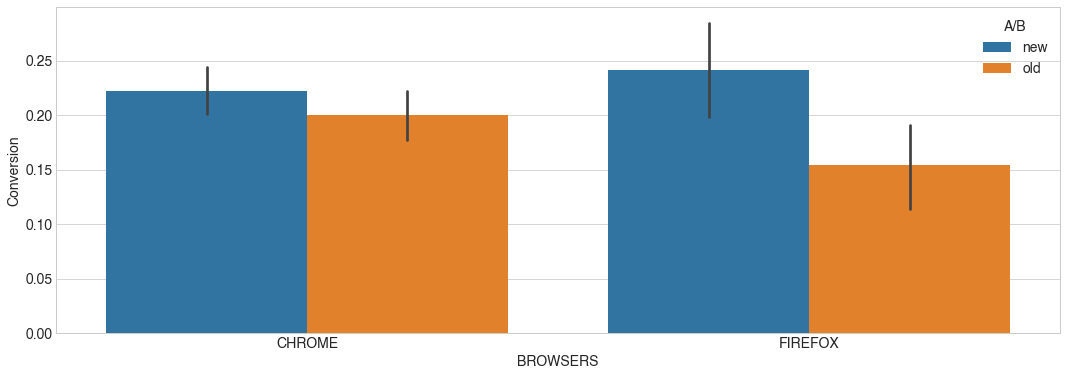

In [261]:
# BROWSERS ON mobile
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='BROWSERS'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='WEB'], ax=ax)
plt.show()

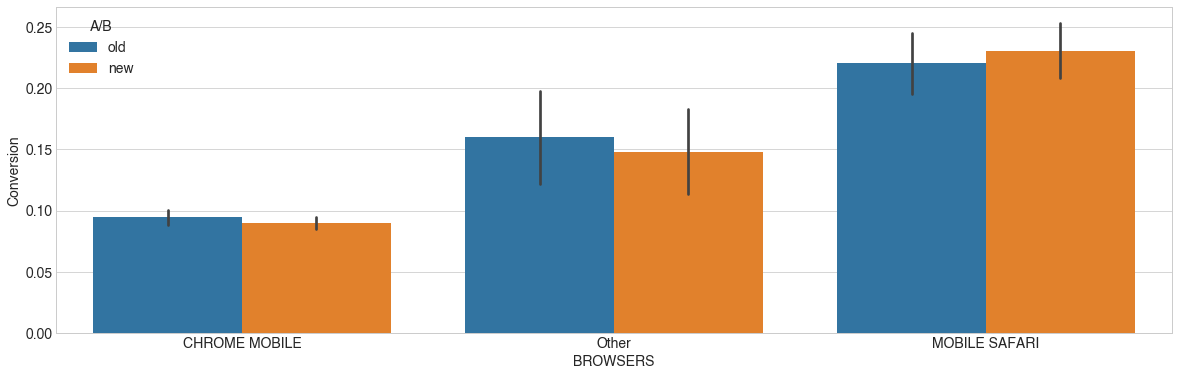

In [274]:
# BROWSERS ON mobile
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x='BROWSERS'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='MOB'], ax=ax)
plt.show()

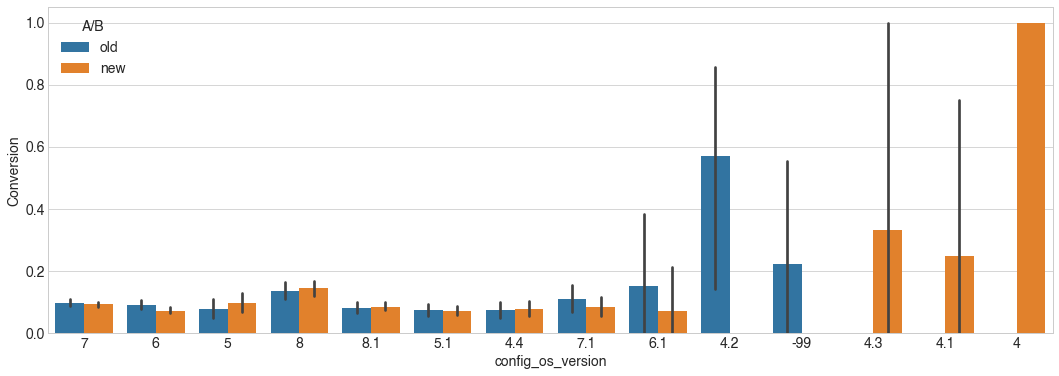

In [293]:
# BROWSERS ON mobile
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='config_os_version'
            , y='Conversion'
            , hue='A/B'
            , data=split2 [split2.BROWSERS=='CHROME MOBILE']
            #, data=split2[split2.BROWSERS=='CHROME MOBILE']
            , ax=ax)
plt.show()

# Testing the hypothesis

In [122]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


control_results = ab_test[ab_test['A/B'] == 'old']['Conversion']
test_results = ab_test[ab_test['A/B'] == 'new']['Conversion']

n_con = control_results.count()
n_test = test_results.count()
successes = [control_results.sum(), test_results.sum()]
nobs = [n_con, n_test]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_test), (upper_con, upper_test) = proportion_confint(successes
                                                                      , nobs=nobs
                                                                      , alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_test:.3f}, {upper_test:.3f}]')

z statistic: 0.09
p-value: 0.926
ci 95% for control group: [0.116, 0.135]
ci 95% for treatment group: [0.116, 0.134]


# Drawing conclusions

Since our p-value=0.926 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different (let alone better) than our old one :(
Additionally, if we look at the confidence interval for the treatment group ([0.116, 0.135], or 11.6-13.5%) we notice that:
It includes our baseline value of 13% conversion rate
It does not include our target value of 15% (the 2% uplift we were aiming for)
What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board!

## Segment Summary

### Рекомендации к данным

**1) Необходимо понимать длительность проведения А/В теста и поведение пользователей во времени - добавить колонку timestamp.
** 2) Отсутствует user_id - хотелось бы проверить по пользователю или Cookies-файлу не было ли повторных транзакций у форме. И не было ли в пользователя пересечений тестовая/контрольная группа.

### Рекомендации к примению

в разрезе формы A/B (old, new) - conv=1
в разрезе платформ
